Import all the packages that we need during the project

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy
import math

Let's start with loading dataset, in order to implement it we define function load_data

In [15]:
def load_data(filename):
    data = np.loadtxt(filename, delimiter=',')
    X = data[:,:2]
    y = data[:,2]
    return X, y

In [16]:
# load dataset
X, y = load_data("data/data_linear.txt")

Let's split data into training set and test set

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=1)

The following code shows the dimensions of training and test sets

In [18]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('The shape of X_train is: ' + str(X_test.shape))
print ('The shape of y_train is: ' + str(y_test.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (70, 2)
The shape of y_train is: (70,)
The shape of X_train is: (30, 2)
The shape of y_train is: (30,)
We have m = 70 training examples


Before starting to implement any algorithm it is a good idea to visualize dataset. The code below displays the data on 2D plot, where the axes are two tests and positive and negative examples are shown with different colors. We define function plot_data to display the plot

In [19]:
def plot_train_data(X, y, pos_label="Accepted train", neg_label="Rejected train"):
    positive = y == 1
    negative = y == 0
    
    # Plot examples
   
    plt.plot(X_train[positive, 0], X_train[positive, 1], 'k+', label=pos_label)
    plt.plot(X_train[negative, 0], X_train[negative, 1], 'ko', label=neg_label)
    

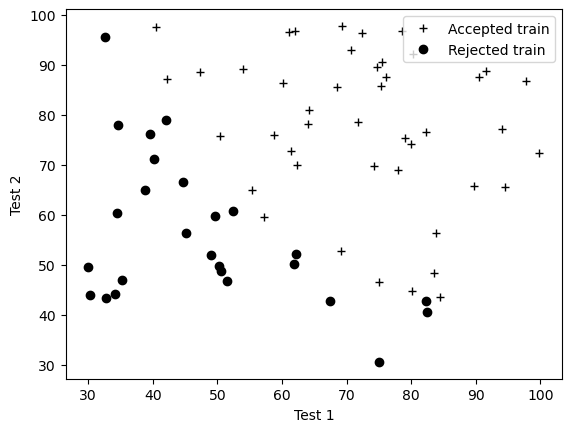

In [20]:
# Plot examples
plot_train_data(X_train, y_train)

# Set the y-axis label
plt.ylabel('Test 2') 
# Set the x-axis label
plt.xlabel('Test 1') 
plt.legend(loc="upper right")
plt.show()

Our goal is to build logistic regression model to fit this data. With this model we can then predict if the microchip is accepted or rejected based on test result

Recall that for logistic regression, the model is represented as

$$ f_{\mathbf{w},b}(x) = g(\mathbf{w}\cdot \mathbf{x} + b)$$
where function $g$ is the sigmoid function. The sigmoid function is defined as:

$$g(z) = \frac{1}{1+e^{-z}}$$

Let's implement the sigmoid function first, so it can be used by the rest of this assignment.

<a name='ex-01'></a>

Note that 
- `z` is not always a single number, but can also be an array of numbers. 
- If the input is an array of numbers, we'd like to apply the sigmoid function to each value in the input array.

In [21]:
# UNQ_C1
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
         
    """
          
    ### START CODE HERE ### 
    g = 1/(1+np.exp(-z))
    ### END SOLUTION ###  
    
    return g

<a name="2.4"></a>
###  Cost function for logistic regression

In this section, we will implement the cost function for logistic regression.

<a name='ex-02'></a>

The cost function for logistic regression is of the form 

$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

where
* m is the number of training examples in the dataset


* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is - 

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
    
    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$, which is the actual label

*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x^{(i)}} + b)$ where function $g$ is the sigmoid function.
    * It might be helpful to first calculate an intermediate variable $z_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x^{(i)}} + b = w_0x^{(i)}_0 + ... + w_{n-1}x^{(i)}_{n-1} + b$ where $n$ is the number of features, before calculating $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(z_{\mathbf{w},b}(\mathbf{x}^{(i)}))$

In [22]:
# UNQ_C2
# GRADED FUNCTION: compute_cost
def compute_cost(X, y, w, b, lambda_= 1):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : scalar Values of bias parameter of the model
      lambda_: unused placeholder
    Returns:
      total_cost: (scalar)         cost 
    """

    m, n = X.shape
    
    ### START CODE HERE ###
    cost = 0
    for i in range(m):
        z = np.dot(X[i],w) + b
        f_wb = sigmoid(z)
        cost += -y[i]*np.log(f_wb) - (1-y[i])*np.log(1-f_wb)
    total_cost = cost/m
    
    ### END CODE HERE ### 

    return total_cost

<a name="2.5"></a>
### Gradient for logistic regression

In this section, we will implement the gradient for logistic regression.

The gradient descent algorithm is:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

where, parameters $b$, $w_j$ are all updated simultaniously


<a name='ex-03'></a>

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$
* m is the number of training examples in the dataset

    
*  $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the actual label


In [23]:
# UNQ_C3
# GRADED FUNCTION: compute_gradient
def compute_gradient(X, y, w, b, lambda_=None): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X : (ndarray Shape (m,n)) variable such as house size 
      y : (array_like Shape (m,1)) actual value n
      w : (array_like Shape (n,1)) values of parameters of the model      
      b : (scalar)                 value of parameter of the model 
      lambda_: unused placeholder.
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w. 
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b. 
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    ### START CODE HERE ### 
    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          
        err_i  = f_wb_i  - y[i]                       
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   
    dj_db = dj_db/m                                   
        
    ### END CODE HERE ###

        
    return dj_db, dj_dw

In [24]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (array_like Shape (m, n)
      y :    (array_like Shape (m,))
      w_in : (array_like Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)                 Initial value of parameter of the model
      cost_function:                  function to compute cost
      alpha : (float)                 Learning rate
      num_iters : (int)               number of iterations to run gradient descent
      lambda_ (scalar, float)         regularization constant
      
    Returns:
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

In [25]:
def plot_decision_boundary(w, b, X, y):
    # Credit to dibgerge on Github for this plotting code
     
    plot_train_data(X_train[:, 0:2],y)
    
    if X.shape[1] <= 2:
        plot_x = np.array([min(X[:, 0]), max(X[:, 0])])
        plot_y = (-1. / w[1]) * (w[0] * plot_x + b)
        
        plt.plot(plot_x, plot_y, c="b")
        
    else:
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)
        
        z = np.zeros((len(u), len(v)))

        # Evaluate z = theta*x over the grid
        for i in range(len(u)):
            for j in range(len(v)):
                z[i,j] = sig(np.dot(map_feature(u[i], v[j]), w) + b)
        
        # important to transpose z before calling contour       
        z = z.T
        
        # Plot z = 0
        plt.contour(u,v,z, levels = [0.5], colors="g")

In [26]:
np.random.seed(1)
initial_w = 0.01 * (np.random.rand(2).reshape(-1,1) - 0.5)
initial_b = -8


# Some gradient descent settings
iterations = 10000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b, 
                                   compute_cost, compute_gradient, alpha, iterations, 0)

Iteration    0: Cost     0.82   
Iteration 1000: Cost     0.27   
Iteration 2000: Cost     0.27   
Iteration 3000: Cost     0.27   
Iteration 4000: Cost     0.27   
Iteration 5000: Cost     0.27   
Iteration 6000: Cost     0.27   
Iteration 7000: Cost     0.27   
Iteration 8000: Cost     0.27   
Iteration 9000: Cost     0.27   
Iteration 9999: Cost     0.27   


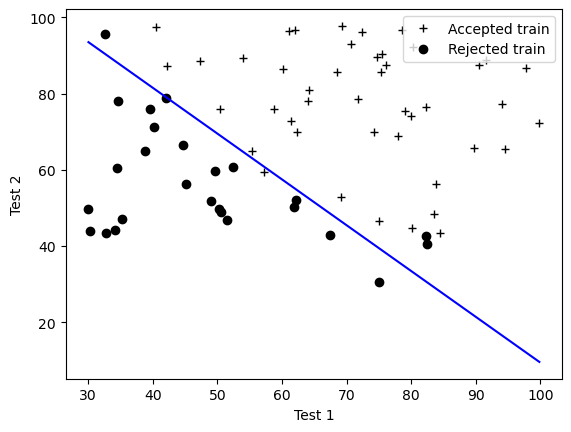

In [27]:
plot_decision_boundary(w, b, X_train, y_train)
# Set the y-axis label
plt.ylabel('Test 2') 
# Set the x-axis label
plt.xlabel('Test 1') 
plt.legend(loc="upper right")
plt.show()

<a name="2.8"></a>
###  Evaluating logistic regression

We can evaluate the quality of the parameters we have found by seeing how well the learned model predicts on our training set. 

We will implement the `predict` function below to do this.

- First we need to compute the prediction from the model $f(x^{(i)}) = g(w \cdot x^{(i)})$ for every example 
- We've implemented this before in the parts above
- We interpret the output of the model ($f(x^{(i)})$) as the probability that $y^{(i)}=1$ given $x^{(i)}$ and parameterized by $w$.
- Therefore, to get a final prediction ($y^{(i)}=0$ or $y^{(i)}=1$) from the logistic regression model, we can use the following heuristic -

  if $f(x^{(i)}) >= 0.5$, predict $y^{(i)}=1$
  
  if $f(x^{(i)}) < 0.5$, predict $y^{(i)}=0$

In [28]:
# UNQ_C4
# GRADED FUNCTION: predict

def predict(X, w, b): 
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w
    
    Args:
    X : (ndarray Shape (m, n))
    w : (array_like Shape (n,))      Parameters of the model
    b : (scalar, float)              Parameter of the model

    Returns:
    p: (ndarray (m,1))
        The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape   
    p = np.zeros(m)
   
    ### START CODE HERE ### 
    # Loop over each example
    for i in range(m):   
        z_wb = np.dot(X[i],w) 
        # Loop over each feature
        for j in range(n): 
            # Add the corresponding term to z_wb
            z_wb += 0
        
        # Add bias term 
        z_wb += b
        
        # Calculate the prediction for this example
        f_wb = sigmoid(z_wb)

        # Apply the threshold
        p[i] = 1 if f_wb>0.5 else 0
        
    ### END CODE HERE ### 
    return p

Now let's use this to compute the accuracy on the training set

In [29]:
#Compute accuracy on our training set
p = predict(X_test, w,b)
print('Train Accuracy: %f'%(np.mean(p == y_test) * 100))

Train Accuracy: 86.666667


Let's add plot of test data to the previous plot of training data with decision boundary

In [30]:
def plot_test_data(X, y, pos_label="y=1", neg_label="y=0"):
    positive = y == 1
    negative = y == 0
    
    # Plot examples
    plt.plot(X_test[positive, 0], X_test[positive, 1], 'r+', label=pos_label)
   
    plt.plot(X_test[negative, 0], X_test[negative, 1], 'ro', label=neg_label)
    

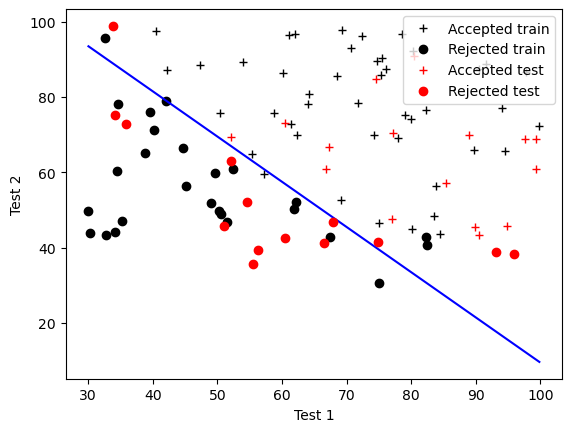

In [31]:
plot_decision_boundary(w, b, X_train, y_train)

# Plot examples
plot_test_data(X_test, y_test[:], pos_label="Accepted test", neg_label="Rejected test")

# Set the y-axis label
plt.ylabel('Test 2') 
# Set the x-axis label
plt.xlabel('Test 1') 
plt.legend(loc="upper right")
plt.show()